![Zip Codes](../images/metro-atlanta-zip-codes-map.jpeg)

# Real Estate Investment Project P1: EDA

**Author:** Sierra Stanton
***

## Overview

This project analyses real estate data from Zillow Research to determine which areas are prime for investment. We have been charged with helping Hellbent Investments narrow down the zipcodes that they should target as they plan for this next round of outspend. We'll use Zillow's dataset to dive into home values in Atlanta across time, and narrow down five zipcodes worthy of investment according to project ROI.

## Business Problem

We' be forecasting real estate prices of various zip codes using data from [Zillow Research](https://www.zillow.com/research/data/). For this project, we'll will be acting as a consultant for Hellbent Investments, a real-estate investment firm focused on development in Atlanta, GA.

Hellbent Investments has asked me what seems like a simple question:

> What are the top 5 best zip codes for us to invest in?

In order to provide a solid recommendation, we met with the firm and determined that projected ROI across the next three years is the best way to narrow down the zipcodes they'll want to focus on.

First, we'll investigate home value data across time within Atlanta's zipcodes. Second, we'll investigate the zipcodes themselves to gauge potential contributing factors. Third, we'll use time series forecasting via ARIMA and Facebook Prophet to chart out future home values and narrow down our list of zipcodes to just five targets.

## Data Understanding

Data will be used from the following source:
* __[Zillow Research](https://www.zillow.com/research/)__ - this sector of Zillow aims to be the most open, authoritative source for timely and accurate housing data and unbiased insight.

Zillow Research's Zillow Data (`zillow_data.csv`): this dataset shows us the average housing sales prices in the United States based on location while shedding light on other location-focused aspects through rankings such as population density. This set shows us information on over 14,000 zip codes - let's explore it further.

In [1]:
# import our chosen packages and necessary libraries for analysis
import pandas as pd
import numpy as np
import pandas.tseries
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import datetime
from matplotlib.pylab import rcParams
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

### Import: Zillow Research's Zillow Dataset

In [2]:
# import our Zillow dataset
df_z = pd.read_csv('../data/zillow_data.csv')
df_z.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [3]:
# preview our dataset
df_z.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Here we see average sales prices from **1996-2018** and can dive deeper via the following columns:
1. `RegionID`
2. `RegionName` - note we can see this mimics a zipcode
3. `City`
4. `State`
5. `Metro`
6. `CountyName`
7. `SizeRank` - this is a zillow-based ranking system that gives us insight into the population density. The lower the score, the higher the population density.

## Data Preparation & Exploratory Data Analysis

### A. Clean Up Our Dataset
With this dataframe, we'll take the following actions:
1. Filter our data down to relevant Atlanta zipcodes
2. Explore our data through visualizations and appropriate grouping

## Filter data for zipcodes specific to Atlanta

We're focusing on zip codes based in the city of Atlanta due to the location and interests of the firm that hired us. We will use the range of zip codes within the city and aim to narrow down to a top five at the conclusion of this project that are deemed most investment worthy from the angle of projected ROI.

In [4]:
# narrow our zip codes down for relevancy

df_atl = df_z.loc[(df_z['Metro'] == 'Atlanta') & (df_z['City'] == 'Atlanta')] # 12 rows, 272 columns
df_atl

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
227,71050,30331,Atlanta,GA,Atlanta,Fulton,228,97100.0,97700.0,98400.0,...,130300,131300,132700,134000,135100,137000,139400,140800,141500,141600
1097,71029,30309,Atlanta,GA,Atlanta,Fulton,1098,260400.0,261700.0,262900.0,...,780200,785900,797400,807600,813500,819200,824900,834500,850300,860700
1223,71043,30324,Atlanta,GA,Atlanta,Fulton,1224,189400.0,190800.0,192300.0,...,506500,509600,515100,519600,523900,528500,532600,537900,543700,545700
1758,71036,30316,Atlanta,GA,Atlanta,Fulton,1759,62300.0,62300.0,62300.0,...,240900,244200,247900,251700,255300,258800,261600,264300,268700,272500
1787,71025,30305,Atlanta,GA,Atlanta,Fulton,1788,297200.0,299000.0,300900.0,...,860000,863400,868200,871200,872400,876800,885600,892900,897600,898200
2757,71028,30308,Atlanta,GA,Atlanta,Fulton,2758,138700.0,139400.0,140100.0,...,524200,529000,539200,547200,557000,570500,581000,585900,594000,599300
3261,71026,30306,Atlanta,GA,Atlanta,Fulton,3262,223100.0,225200.0,227400.0,...,733900,737500,744700,751200,755000,760300,766600,773200,781700,787000
4455,71046,30327,Atlanta,GA,Atlanta,Fulton,4456,515500.0,515900.0,516300.0,...,1135600,1140900,1152100,1158400,1158000,1162000,1173000,1173200,1168400,1165700
4643,71027,30307,Atlanta,GA,Atlanta,Fulton,4644,158900.0,159700.0,160500.0,...,539700,542300,544000,547600,554300,563200,569700,575400,582900,587100
6650,71037,30317,Atlanta,GA,Atlanta,Fulton,6651,51800.0,52500.0,53200.0,...,362500,362500,362300,366000,372400,379200,384900,388400,390400,391600


In [5]:
# check for missing values
df_atl.isnull().values.any()

False

In [6]:
# create replica dataframe for testing
df_atl2 = df_atl.copy()

In [7]:
df_atl2

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
227,71050,30331,Atlanta,GA,Atlanta,Fulton,228,97100.0,97700.0,98400.0,...,130300,131300,132700,134000,135100,137000,139400,140800,141500,141600
1097,71029,30309,Atlanta,GA,Atlanta,Fulton,1098,260400.0,261700.0,262900.0,...,780200,785900,797400,807600,813500,819200,824900,834500,850300,860700
1223,71043,30324,Atlanta,GA,Atlanta,Fulton,1224,189400.0,190800.0,192300.0,...,506500,509600,515100,519600,523900,528500,532600,537900,543700,545700
1758,71036,30316,Atlanta,GA,Atlanta,Fulton,1759,62300.0,62300.0,62300.0,...,240900,244200,247900,251700,255300,258800,261600,264300,268700,272500
1787,71025,30305,Atlanta,GA,Atlanta,Fulton,1788,297200.0,299000.0,300900.0,...,860000,863400,868200,871200,872400,876800,885600,892900,897600,898200
2757,71028,30308,Atlanta,GA,Atlanta,Fulton,2758,138700.0,139400.0,140100.0,...,524200,529000,539200,547200,557000,570500,581000,585900,594000,599300
3261,71026,30306,Atlanta,GA,Atlanta,Fulton,3262,223100.0,225200.0,227400.0,...,733900,737500,744700,751200,755000,760300,766600,773200,781700,787000
4455,71046,30327,Atlanta,GA,Atlanta,Fulton,4456,515500.0,515900.0,516300.0,...,1135600,1140900,1152100,1158400,1158000,1162000,1173000,1173200,1168400,1165700
4643,71027,30307,Atlanta,GA,Atlanta,Fulton,4644,158900.0,159700.0,160500.0,...,539700,542300,544000,547600,554300,563200,569700,575400,582900,587100
6650,71037,30317,Atlanta,GA,Atlanta,Fulton,6651,51800.0,52500.0,53200.0,...,362500,362500,362300,366000,372400,379200,384900,388400,390400,391600


## Explore our data through visualizations and appropriate grouping

In [8]:
# identify our key zipcode column for clarity
df_atl.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
df_atl.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
227,71050,30331,Atlanta,GA,Atlanta,Fulton,228,97100.0,97700.0,98400.0,...,130300,131300,132700,134000,135100,137000,139400,140800,141500,141600
1097,71029,30309,Atlanta,GA,Atlanta,Fulton,1098,260400.0,261700.0,262900.0,...,780200,785900,797400,807600,813500,819200,824900,834500,850300,860700
1223,71043,30324,Atlanta,GA,Atlanta,Fulton,1224,189400.0,190800.0,192300.0,...,506500,509600,515100,519600,523900,528500,532600,537900,543700,545700
1758,71036,30316,Atlanta,GA,Atlanta,Fulton,1759,62300.0,62300.0,62300.0,...,240900,244200,247900,251700,255300,258800,261600,264300,268700,272500
1787,71025,30305,Atlanta,GA,Atlanta,Fulton,1788,297200.0,299000.0,300900.0,...,860000,863400,868200,871200,872400,876800,885600,892900,897600,898200


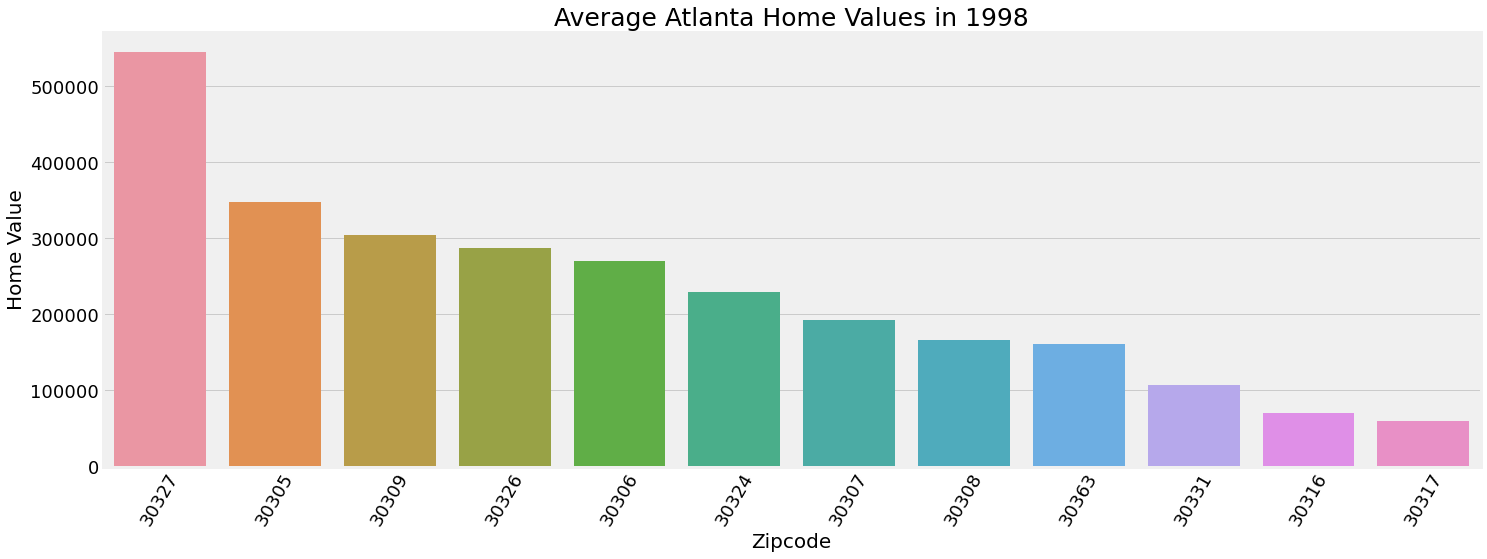

In [9]:
plt.figure(figsize=(22,8))
sns.barplot(x='Zipcode', y='1998-01', data=df_atl, order=df_atl.sort_values('1998-01', ascending=False).Zipcode)
plt.title('Average Atlanta Home Values in 1998',fontsize=25)
plt.tick_params(labelsize=18)
plt.xlabel('Zipcode', fontsize=20)
plt.ylabel('Home Value', fontsize=20)
plt.xticks(rotation=60)
plt.show()

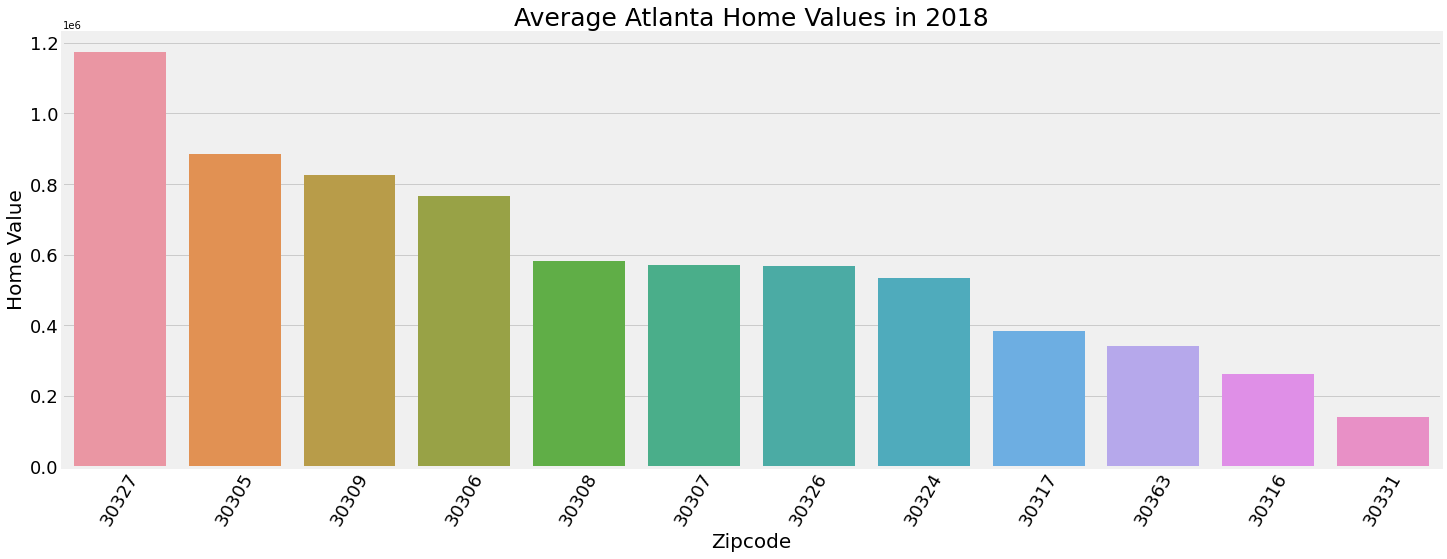

In [10]:
plt.figure(figsize=(22,8))
sns.barplot(x='Zipcode', y='2018-01', data=df_atl, order=df_atl.sort_values('2018-01', ascending=False).Zipcode)
plt.title('Average Atlanta Home Values in 2018',fontsize=25)
plt.tick_params(labelsize=18)
plt.xlabel('Zipcode', fontsize=20)
plt.ylabel('Home Value', fontsize=20)
plt.xticks(rotation=60)
plt.show()

From the above, we can clearly see how average housing values jumped over the course of twenty years and that the zipcodes shuffled rankings across this time, while the top three zipcodes retained their position.

If we'd like to know the percise amounts and use additional plots to gauge that change across the span of twenty years, I'll create a helpful dataframe and visualization below.

In [11]:
# side by side twenty year comparison
comp_twenty = pd.DataFrame()
comp_twenty['Zipcode'] = df_atl['Zipcode']
comp_twenty['1998-01'] = df_atl['1998-01']
comp_twenty['2018-01'] = df_atl['2008-01']
comp_twenty.set_index('Zipcode', inplace=True)
comp_twenty

,1998-01,2018-01
Zipcode,,
30331,107300.0,164700.0
30309,304700.0,595700.0
30324,229800.0,413500.0
30316,70500.0,175200.0
30305,347600.0,691300.0
30308,166000.0,362900.0
30306,269700.0,528600.0
30327,544700.0,978700.0
30307,192700.0,367200.0


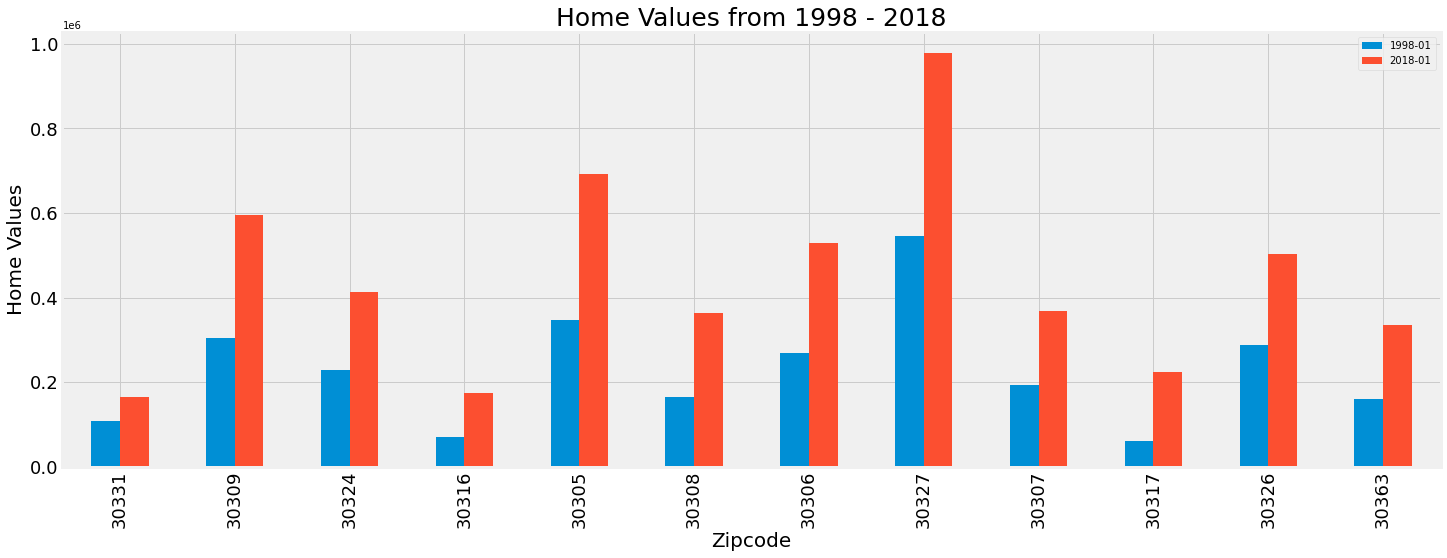

In [12]:
comp_twenty.plot(kind='bar', figsize=(22, 8))                                       
plt.xlabel("Zipcodes")
plt.ylabel("Home Value")
plt.title('Home Values from 1998 - 2018',fontsize=25)
plt.xlabel('Zipcode', fontsize=20)
plt.ylabel('Home Values', fontsize=20)
plt.tick_params(labelsize=18)
plt.show()

For now, let's dive deeper into the `SizeRank` column provided.

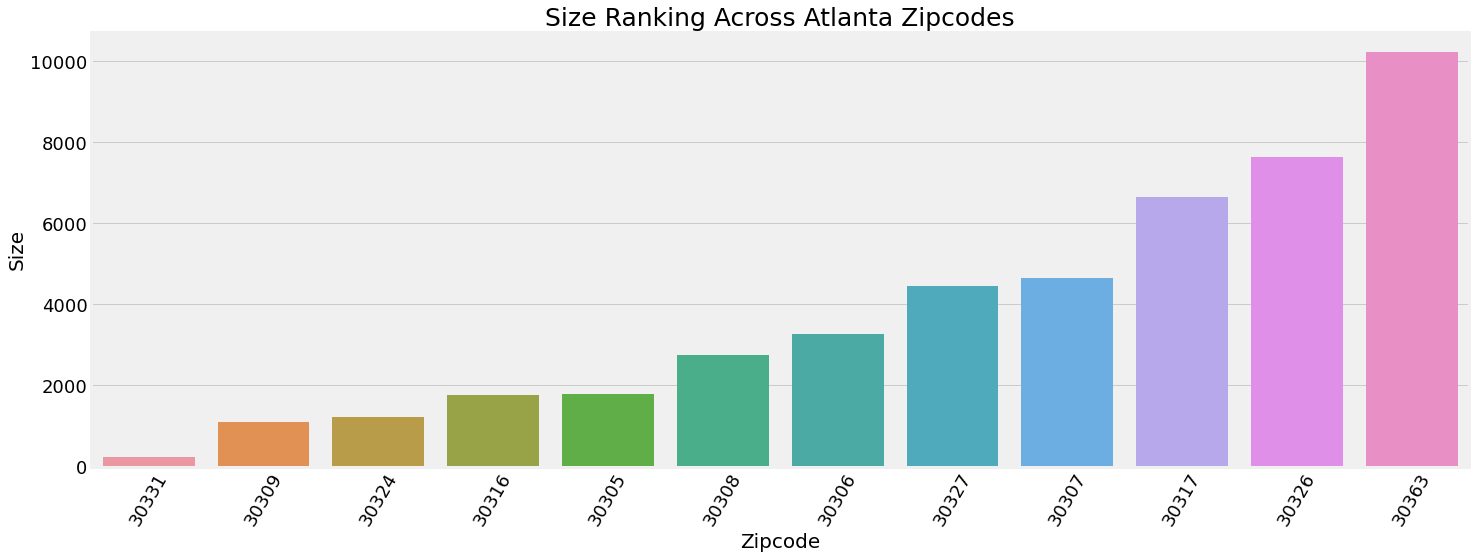

In [13]:
plt.figure(figsize=(22,8))
sns.barplot(x='Zipcode', y='SizeRank', data=df_atl, order=df_atl.sort_values('SizeRank', ascending=True).Zipcode)
plt.title('Size Ranking Across Atlanta Zipcodes',fontsize=25)
plt.xlabel('Zipcode', fontsize=20)
plt.ylabel('Size', fontsize=20)
plt.tick_params(labelsize=18)
plt.xticks(rotation=60)
plt.show()

From the above, we get a clearer picture of population density in Atlanta. We have to keep in mind that a lower score equals a higher population density with 30331 being the most dense and 30362 being the least populated.

Note that our highest 30331 also reflects the lowest home value in 2018. While we will primarily measure ROI to gauge the top five zip codes, this is still worth noting and relaying later in our analysis.

One more area that'll be helpful to explore prior to further data cleaning is how these price values changed across time to have an intial gauge for trends and seaonality.

### Clean and Process Data for Further EDA

In [14]:
# drop unnecessary columns
df_atl.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=True)

# reset our index
df_atl.reset_index(drop=True, inplace=True)

# preview data
display(df_atl)
df_atl.info()

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,30331,97100.0,97700.0,98400.0,99100.0,100000.0,100900.0,101900.0,102900.0,104000.0,...,130300,131300,132700,134000,135100,137000,139400,140800,141500,141600
1,30309,260400.0,261700.0,262900.0,264200.0,265400.0,266700.0,268100.0,269500.0,271100.0,...,780200,785900,797400,807600,813500,819200,824900,834500,850300,860700
2,30324,189400.0,190800.0,192300.0,193900.0,195700.0,197500.0,199400.0,201400.0,203700.0,...,506500,509600,515100,519600,523900,528500,532600,537900,543700,545700
3,30316,62300.0,62300.0,62300.0,62300.0,62300.0,62300.0,62300.0,62300.0,62400.0,...,240900,244200,247900,251700,255300,258800,261600,264300,268700,272500
4,30305,297200.0,299000.0,300900.0,302700.0,304500.0,306300.0,308100.0,309900.0,312200.0,...,860000,863400,868200,871200,872400,876800,885600,892900,897600,898200
5,30308,138700.0,139400.0,140100.0,140900.0,141700.0,142600.0,143500.0,144600.0,145800.0,...,524200,529000,539200,547200,557000,570500,581000,585900,594000,599300
6,30306,223100.0,225200.0,227400.0,229600.0,231800.0,234100.0,236600.0,239000.0,241800.0,...,733900,737500,744700,751200,755000,760300,766600,773200,781700,787000
7,30327,515500.0,515900.0,516300.0,516800.0,517500.0,518700.0,520300.0,522300.0,524900.0,...,1135600,1140900,1152100,1158400,1158000,1162000,1173000,1173200,1168400,1165700
8,30307,158900.0,159700.0,160500.0,161300.0,162200.0,163100.0,164100.0,165200.0,166500.0,...,539700,542300,544000,547600,554300,563200,569700,575400,582900,587100
9,30317,51800.0,52500.0,53200.0,53900.0,54500.0,55200.0,55800.0,56300.0,56800.0,...,362500,362500,362300,366000,372400,379200,384900,388400,390400,391600


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Columns: 266 entries, Zipcode to 2018-04
dtypes: float64(219), int64(47)
memory usage: 25.1 KB


### Gauge Housing Price Values Over Time Across Zipcode

In [15]:
# create replica dataframe for further analysis
df_atl_gauge = df_atl.copy()

# make key column string type for plotting
df_atl_gauge['Zipcode'] = df_atl_gauge['Zipcode'].astype(str)

# transpose data to rows
df_atl_gauge=df_atl_gauge.transpose()
df_atl_gauge.head()

,0,1,2,3,4,5,6,7,8,9,10,11
Zipcode,30331,30309,30324,30316,30305,30308,30306,30327,30307,30317,30326,30363
1996-04,97100,260400,189400,62300,297200,138700,223100,515500,158900,51800,238100,131400
1996-05,97700,261700,190800,62300,299000,139400,225200,515900,159700,52500,240100,131700
1996-06,98400,262900,192300,62300,300900,140100,227400,516300,160500,53200,242100,132000
1996-07,99100,264200,193900,62300,302700,140900,229600,516800,161300,53900,244000,132300


In [16]:
# rename columns
header = df_atl_gauge.iloc[0] ## grab first row for the column names
df_atl_gauge = df_atl_gauge[1:] ## take all data after first row
df_atl_gauge.columns = header ## reassign all columns to zipcodes
df_atl_gauge.head()

Zipcode,30331,30309,30324,30316,30305,30308,30306,30327,30307,30317,30326,30363
1996-04,97100,260400,189400,62300,297200,138700,223100,515500,158900,51800,238100,131400
1996-05,97700,261700,190800,62300,299000,139400,225200,515900,159700,52500,240100,131700
1996-06,98400,262900,192300,62300,300900,140100,227400,516300,160500,53200,242100,132000
1996-07,99100,264200,193900,62300,302700,140900,229600,516800,161300,53900,244000,132300
1996-08,100000,265400,195700,62300,304500,141700,231800,517500,162200,54500,245800,132800


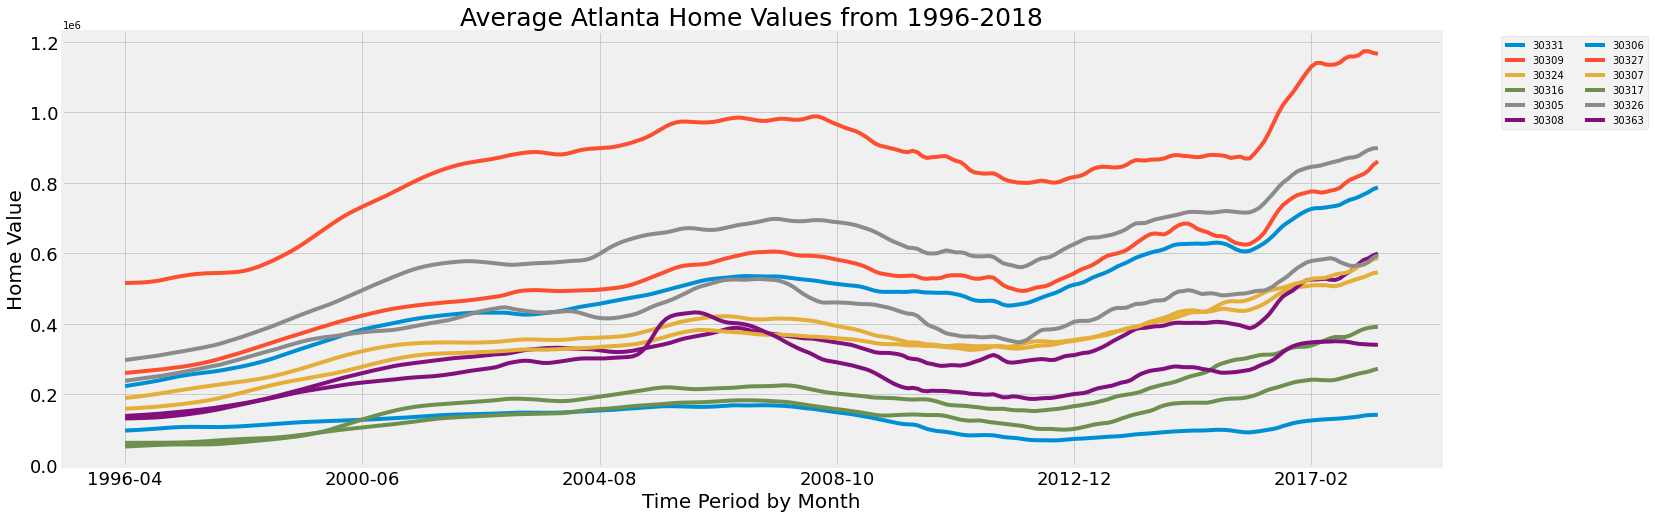

In [17]:
df_atl_gauge.plot(figsize=(22, 8))
plt.title('Average Atlanta Home Values from 1996-2018',fontsize=25)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel('Time Period by Month', fontsize=20)
plt.ylabel('Home Value', fontsize=20)
plt.tick_params(labelsize=18)
plt.show()

From the above, we can see that the housing crisis that came to head in 2008 did impact Atlanta zipcodes and is something we'd like not to include as an accurate gauage for future planning. Because of this, we'll split this data and see if we can remove an unhelpful trend.

In [18]:
# remove housing data prior to 2010
df_atl_gauge = df_atl_gauge.loc[df_atl_gauge.index >= '2010-01']
df_atl_gauge.head()

Zipcode,30331,30309,30324,30316,30305,30308,30306,30327,30307,30317,30326,30363
2010-01,114600,536400,347300,142400,615800,302700,490700,887100,338600,185400,428800,217000
2010-02,114300,536900,347000,142800,615000,300300,492200,890700,338600,185200,427600,218200
2010-03,111800,533600,346800,142400,612500,299000,491800,886300,338800,185600,422000,215700
2010-04,106600,528500,343700,141600,605400,294400,489600,875400,337700,185900,410400,210000
2010-05,101600,527600,341300,141100,600000,288300,488700,870300,337100,185400,398300,208600


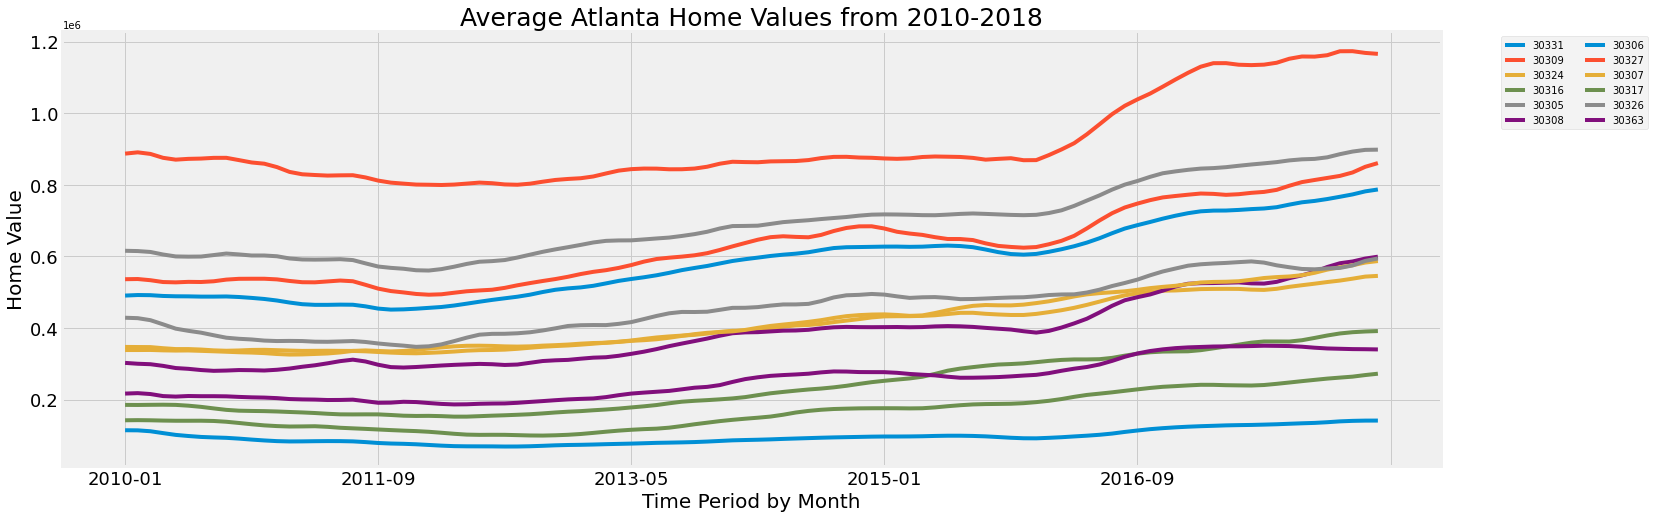

In [19]:
# gauge housing price values across time for our last eight years of data

df_atl_gauge.plot(figsize=(22, 8))
plt.title('Average Atlanta Home Values from 2010-2018', fontsize=25)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel('Time Period by Month', fontsize=20)
plt.ylabel('Home Value', fontsize=20)
plt.tick_params(labelsize=18)
plt.show()

This looks a lot more even for our analysis! We do want to note above that most values across zipcodes begin rising from 2015-16.

By trimming our data down to the past eight years we can better access our zipcodes and their future trajectory. This will allow us a swath of years to ascertain from while helping ensure we're devaluing the fluctuating housing crisis of 08'.

## Process Data for Model Analysis (continued in __[next notebook](./investment_analysis-modeling.ipynb)__)